In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import signal
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

In [2]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = data # signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel

In [3]:
def fake_pulse(pulse, amp):
    return_pulse = []
    for i in pulse:
        if i != 0:
            return_pulse.append(i+ np.random.uniform(-amp, amp))
        else:
            return_pulse.append(0)
    return return_pulse

In [4]:
gp_table = pd.read_table('typized_dataset_for_dina.csv', sep='\t')
pattern = np.genfromtxt('total_profile.txt')

T_SCATTERING = 15.85

In [5]:
noises = gp_table[gp_table.type == 0]
pulses = gp_table[gp_table.type == 1]

In [6]:
def new_pulse(pulse):
    amp_pls = np.std(pulse[:20])/3
    return (pulse
            + np.random.normal(loc=0.0, scale=amp_pls, size=len(pulse))
            - np.random.normal(loc=0.0, scale=amp_pls, size=len(pulse)))

def screan(t, t_s):
    if t < 0:
        return 0
    else:
        return np.exp(-t/t_s)

def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

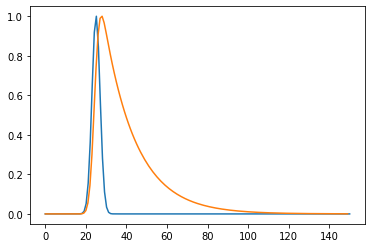

In [7]:
x = np.linspace(0, 150, 150)
gs = gauss(x, 0.1, 25, 2)
scr = [screan(i, T_SCATTERING) for i in x] 
plt.plot(x, gs/max(gs))
plt.plot(np.convolve(gs, scr,'full')[:150]/max(np.convolve(scr, gs)))
plt.show()

In [60]:
def my_pulse(x,a,x0,sigma, t_s):
    gs = gauss(x, a, x0, sigma)
    scr = [screan(i, t_s) for i in x] 
    return np.convolve(scr, gs, 'full')[:150]

+ Создаем базу для новых импульсов
+ Берется импульс из базы оригинальных
+ Определяется амплитуда шумов импульса в начале записи
+ Импульс фитируется 
+ На фитинг накладывается шум с уже определенной амплитудой (10 раз)
+ Каждый размноженый импульс сохраняется в новую базу.
+ Произвести сравнение основных и сгенерированных импульсов

c:\users\professional\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


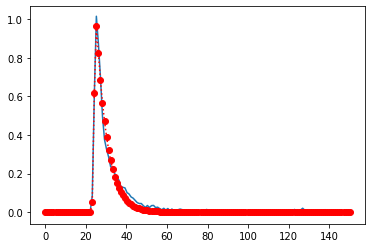

In [61]:
idx_list = []
amp_list = []
mean_list = []
sigma_list = []
t_s_list = []
for idx, row in pulses.iterrows():
    x = np.linspace(0, 150, 150)
    y = np.asarray(pulses.loc[idx][:-1])
    
    # выравнивение импульса относительно 0
    y -= np.median(y[:11])
    
    amp = 1
    mean = 25
    sigma = 3
    t_s = 10
    
    try:
        popt,pcov = curve_fit(my_pulse,x,y,p0=[amp,mean,sigma, t_s])
    
        idx_list.append(idx)
        amp_list.append(popt[0])
        mean_list.append(popt[1])
        sigma_list.append(popt[2])
        t_s_list.append(popt[3])
        
        plt.close()
        plt.plot(x,y, label='data')
        plt.plot(x,my_pulse(x,*popt),'ro:',label='fit')
        plt.savefig(f'./pic_fit_func/{idx}.png', format='png')
        
    except RuntimeError:
        continue

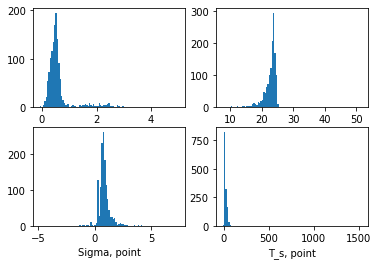

In [43]:
obj_list = [amp_list, mean_list, sigma_list, t_s_list]
x_lable_list = ['Amplitude, point', 'Median, point', 'Sigma, point', 'T_s, point']
plt.close()
for i, obj, lbl in zip([1, 2, 3, 4], obj_list, x_lable_list):
    plt.subplot(2, 2, i)
    bins = np.linspace(min(obj), max(obj), 100)
    plt.hist(obj, bins=bins)
    plt.xlabel(lbl)
plt.show()

In [44]:
for i in obj_list:
    print(min(i), max(i))

-0.07322632950163663 4.996827382630865
7.585941475735448 51.48685823163726
-4.8147104568123495 7.397747923953682
-11.381560394782392 1522.3035725834427


In [48]:
# Удаление слишком выделяющихся элементов
idx_list[t_s_list.index(1522.3035725834427)]


1981

In [10]:
pulses.head(15)

,point_0,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_141,point_142,point_143,point_144,point_145,point_146,point_147,point_148,point_149,type
0,-0.017860,-0.115993,-0.018876,-0.122010,0.001708,-0.033468,0.009227,-0.045617,0.045468,-0.051204,...,0.067686,0.168518,0.068652,0.180395,0.014543,0.088922,0.144311,0.048448,0.063254,1.0
1,-0.015423,-0.121103,-0.027488,0.054510,-0.112701,-0.009987,0.001370,0.004281,0.022356,0.112101,...,0.194870,0.076776,0.045697,0.154932,0.137359,0.161721,0.177655,0.090059,0.141497,1.0
2,-0.056153,-0.107688,-0.046679,-0.014933,-0.083847,-0.109397,0.005563,0.027108,-0.003410,-0.049381,...,0.180607,0.114573,0.143703,0.074355,0.084877,0.024435,0.137469,0.148161,0.057504,1.0
3,-0.052788,-0.065420,-0.093847,-0.033325,0.012959,-0.013712,-0.056375,-0.010271,-0.029532,0.000538,...,0.071399,0.098114,0.062758,0.065868,0.127112,0.098548,-0.005140,0.068418,0.044289,1.0
4,-0.016728,0.013810,0.005636,0.042604,0.025712,0.031541,-0.085983,0.010820,0.038733,0.057719,...,0.050728,0.095785,0.143788,0.008618,0.054098,0.077974,0.094028,-0.003485,0.013365,1.0
5,-0.014684,0.306162,0.060566,0.018731,0.017434,0.177639,-0.181092,-0.088093,-0.066491,-0.060772,...,0.002423,0.081877,-0.031283,-0.008251,0.153251,0.089207,0.035741,-0.016332,0.096780,1.0
6,0.039735,0.259715,-0.066995,-0.015800,0.014410,-0.097562,-0.033319,0.025579,0.132112,-0.033808,...,0.087286,0.087605,-0.013198,0.055516,0.097647,0.101573,0.061378,0.113635,-0.016289,1.0
7,-0.165262,0.019502,0.025097,-0.081668,-0.017692,0.071225,-0.059165,-0.104683,0.088114,-0.059436,...,0.147792,0.031330,0.037853,0.006088,0.017305,0.124815,0.005420,-0.054374,0.117343,1.0
8,-0.045076,0.091324,-0.125490,-0.017384,-0.083159,0.047183,-0.141596,-0.029278,0.093277,-0.042591,...,0.083052,0.004284,0.025242,0.069691,0.060638,0.015775,0.196045,0.163892,-0.006947,1.0
25,-0.086787,0.056570,-0.005130,-0.001107,-0.019243,-0.001900,0.010585,-0.011192,0.019627,0.067352,...,0.096323,0.047252,0.034820,0.070976,0.030435,0.065282,0.005396,0.107616,0.158603,1.0


In [46]:
df = pd.DataFrame(
    list(zip(amp_list, mean_list, sigma_list, t_s_list)),
    columns=['Amplitude', 'Median', 'Sigma', 'T_s'])

<Figure size 800x640 with 0 Axes>

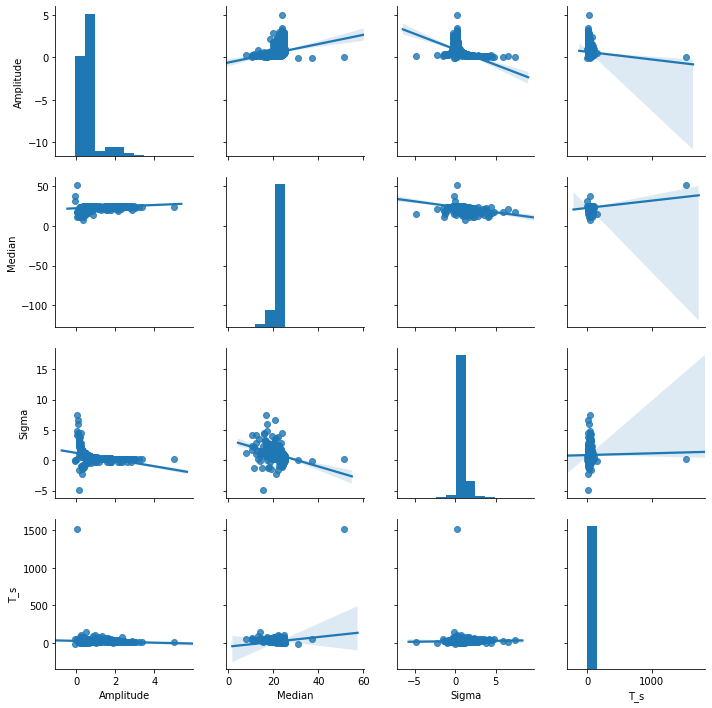

In [47]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="reg")
plt.show()

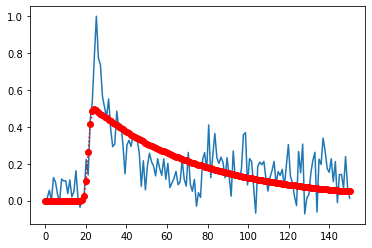

In [151]:
plt.close()
plt.plot(x,y, label='data')
plt.plot(x,my_pulse(x,*popt),'ro:',label='fit')
plt.show()

In [152]:
popt

array([ 0.16963438, 21.6181559 ,  1.23822672, 54.62096697])

In [39]:
pulses['pearson'] = None
for idx, row in pulses.iterrows():
    pulses.loc[idx, 'pearson'] = pearsonr(pattern, pulses.loc[idx][:-2])[0]

c:\users\professional\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\professional\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [59]:
pulses_09 = pulses[(pulses.pearson <= 1) & (pulses.pearson > 0.9)]
pulses_08 = pulses[(pulses.pearson <= 0.9) & (pulses.pearson > 0.8)]
pulses_07 = pulses[(pulses.pearson <= 0.8) & (pulses.pearson > 0.7)]
pulses_06 = pulses[(pulses.pearson <= 0.7)]

In [60]:
print(len(pulses_09), len(pulses_08), len(pulses_07), len(pulses_06))

505 503 240 162


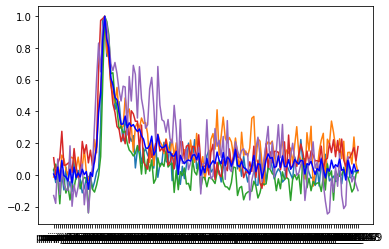

In [68]:
smpl = pulses_08.sample(5).reset_index(drop=True)
plt.close()
for idx in range(5):
    plt.plot(smpl.loc[idx][:-2])
plt.plot(smpl.mean()[:-2], color='b')
#plt.plot(n_1 - 0.25)
#plt.plot(n_2 - 0.5)
#plt.plot(pls + n_1 - n_2)
plt.show()

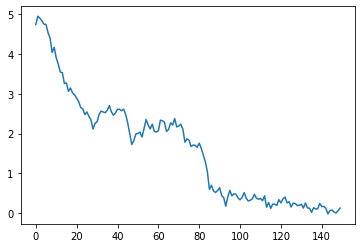

In [73]:
plt.close()
plt.plot(np.correlate(smpl.loc[0][:-2], smpl.loc[4][:-2][::-1], 'same'))
plt.show()

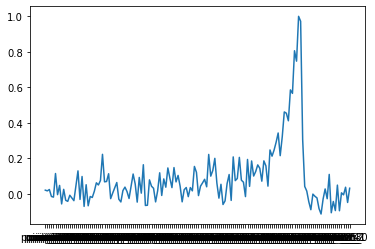

In [74]:
plt.close()
plt.plot(smpl.loc[0][:-2][::-1])
plt.show()

In [31]:
pearsonr(pattern, smpl.loc[4][:-1])[0]

0.7750498918202603

In [18]:
pulses_mega_pack = pd.DataFrame(columns=pulses.columns)
noises_mega_pack = pd.DataFrame(columns=noises.columns)

In [21]:
# Creating addition datasen for pulses
for i in range(20000):
    smpl = pulses.sample(1).reset_index(drop=True)
    pulses_mega_pack.loc[i] = [*new_pulse(smpl.loc[0][:-1]), 1]

In [23]:
# creating addition dataset for noises
count = 0
for j in noises.index:
    for i in range(10):
        test_pulse = list(noises.loc[j][:-1])
        std_end_pulse = 0.13
        fk_pulse = fake_pulse(test_pulse, std_end_pulse)
        noises_mega_pack.loc[count] = [*fk_pulse, 0]
        count += 1

In [24]:
# For vizualization
real_pulse_start_std = []
real_pulse_end_std = []
real_pulse_full_std = []

fake_pulse_start_std = []
fake_pulse_end_std = []
fake_pulse_full_std = []

real_noise_start_std = []
real_noise_end_std = []
real_noise_full_std = []

fake_noise_start_std = []
fake_noise_end_std = []
fake_noise_full_std = []

for idx, row in enumerate(pulses.iterrows()):
    real_pulse_start_std.append(np.std(row[1][0:20]))
    real_pulse_end_std.append(np.std(row[1][-30:-1]))
    real_pulse_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(pulses_mega_pack.iterrows()):
    fake_pulse_start_std.append(np.std(row[1][0:20]))
    fake_pulse_end_std.append(np.std(row[1][-30:-1]))
    fake_pulse_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(noises.iterrows()):
    real_noise_start_std.append(np.std(row[1][0:20]))
    real_noise_end_std.append(np.std(row[1][-30:-1]))
    real_noise_full_std.append(np.std(row[1][:-1]))

for idx, row in enumerate(noises_mega_pack.iterrows()):
    fake_noise_start_std.append(np.std(row[1][0:20]))
    fake_noise_end_std.append(np.std(row[1][-30:-1]))
    fake_noise_full_std.append(np.std(row[1][:-1]))

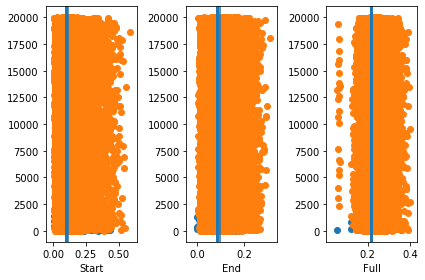

In [25]:
plt.close()
plt.subplot(1, 3, 1)
plt.xlabel('Start')
plt.scatter(real_pulse_start_std, range(len(real_pulse_start_std)))
plt.scatter(fake_pulse_start_std,range(len(fake_pulse_start_std)))
plt.axvline(np.mean(real_pulse_start_std), lw=3)
plt.axvline(np.mean(fake_pulse_start_std))
plt.subplot(1, 3, 2)
plt.xlabel('End')
plt.scatter(real_pulse_end_std, range(len(real_pulse_end_std)))
plt.scatter(fake_pulse_end_std, range(len(fake_pulse_end_std)))
plt.axvline(np.mean(real_pulse_end_std), lw=3)
plt.axvline(np.mean(fake_pulse_end_std))
plt.subplot(1, 3, 3)
plt.xlabel('Full')
plt.scatter(real_pulse_full_std, range(len(real_pulse_full_std)))
plt.scatter(fake_pulse_full_std, range(len(fake_pulse_full_std)))
plt.axvline(np.mean(real_pulse_full_std), lw=3)
plt.axvline(np.mean(fake_pulse_full_std))
plt.tight_layout()
plt.show()

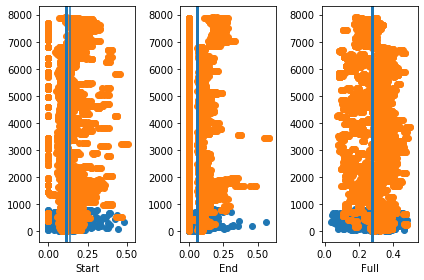

In [27]:
plt.close()
plt.subplot(1, 3, 1)
plt.xlabel('Start')
plt.scatter(real_noise_start_std, range(len(real_noise_start_std)))
plt.scatter(fake_noise_start_std,range(len(fake_noise_start_std)))
plt.axvline(np.mean(real_noise_start_std), lw=3)
plt.axvline(np.mean(fake_noise_start_std))
plt.subplot(1, 3, 2)
plt.xlabel('End')
plt.scatter(real_noise_end_std, range(len(real_noise_end_std)))
plt.scatter(fake_noise_end_std, range(len(fake_noise_end_std)))
plt.axvline(np.mean(real_noise_end_std), lw=3)
plt.axvline(np.mean(fake_noise_end_std))
plt.subplot(1, 3, 3)
plt.xlabel('Full')
plt.scatter(real_noise_full_std, range(len(real_noise_full_std)))
plt.scatter(fake_noise_full_std, range(len(fake_noise_full_std)))
plt.axvline(np.mean(real_noise_full_std), lw=3)
plt.axvline(np.mean(fake_noise_full_std))
plt.tight_layout()
plt.show()

In [157]:
# combine packs together
result_frame = pd.concat([pulses, noises, pulses_mega_pack, noises_mega_pack])

In [158]:
result_frame = result_frame.reset_index(drop=True)

In [159]:
result_frame = result_frame.sample(30100).reset_index(drop=True)

In [160]:
result_frame

,point_0,point_1,point_2,point_3,point_4,point_5,point_6,point_7,point_8,point_9,...,point_141,point_142,point_143,point_144,point_145,point_146,point_147,point_148,point_149,type
0,0.978982,0.600792,0.576295,0.879071,0.748419,0.700882,0.808217,0.756189,0.937267,0.656817,...,-0.170598,-0.040731,0.055434,-0.030381,-0.060119,0.038711,-0.207188,-0.327987,-0.026227,0.0
1,-0.046221,-0.016026,-0.069947,-0.017973,-0.028160,-0.005879,-0.122640,-0.022876,-0.030940,0.005005,...,0.061523,0.025700,0.118280,0.067003,0.090839,-0.069283,-0.008646,0.067241,0.045706,1.0
2,0.027795,0.037606,0.040863,0.135837,0.024407,0.015284,0.004629,-0.028649,-0.050140,0.122780,...,0.024338,-0.025538,0.049220,-0.024554,0.048421,-0.001028,0.128556,0.105247,0.081709,1.0
3,-0.092483,0.024088,0.145415,0.193473,0.088773,0.035256,-0.001771,-0.055982,0.000804,0.064992,...,-0.027176,0.022993,0.010239,-0.031870,0.022775,0.082362,0.054780,0.058370,0.025668,1.0
4,-0.245618,-0.215813,-0.155470,0.132695,0.247526,0.153856,-0.098590,0.013599,0.015258,0.103669,...,0.184631,-0.052737,-0.169983,-0.157704,0.415985,0.178661,0.228058,0.099832,-0.275830,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30095,-0.045956,-0.024024,-0.002831,0.030766,0.016950,0.010178,0.002656,0.021405,-0.026715,-0.003883,...,0.030998,0.107310,0.069951,0.133985,0.092593,0.069622,0.071456,0.031802,0.019237,1.0
30096,-0.046713,-0.079228,-0.011660,0.122095,0.044002,-0.057404,-0.112664,-0.110412,-0.007963,-0.023589,...,0.042004,-0.025379,-0.031888,-0.051869,-0.023643,0.118647,0.107225,0.038447,0.091439,1.0
30097,0.011909,0.028410,-0.027651,0.016606,-0.013588,0.021380,-0.055476,-0.044285,-0.003765,0.012023,...,0.043173,0.038468,0.035248,0.042385,0.028186,0.016542,0.039146,0.056171,0.023695,1.0
30098,0.449334,0.494104,0.414751,0.301929,0.474813,0.378049,0.496939,0.623295,0.415871,0.418447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [169]:
result_frame.to_csv('typized_dataset_for_dina_megaset.csv', sep='\t', header=True, index=False)